In [36]:
import os
import numpy as np
import tifffile
from tqdm import tqdm
def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.
    
    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if (f.endswith('.tiff') or f.endswith('.tif'))])

    tiff_sequence = tifffile.TiffSequence(tiff_files)
    
    # Get the total number of TIFF files
    total_files = len(tiff_files)
    
    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)
            
            # Update progress
            pbar.update(1)
    
    return np.array(volume)

In [37]:
from tqdm import tqdm
def write_sequence(folder_path, name, volume):
    """
    Save a 3D volume as a sequence of TIFF files in a folder.
    
    Args:
    folder_path (str): Path to the folder where TIFF files will be saved.
    name (str): Name of the TIFF files.
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.
    """

    folder_path = folder_path / name

    # Create the folder if it doesn't exist
    Path(folder_path).mkdir(parents=True, exist_ok=True)

    # Save each slice as a TIFF file with progress bar
    with tqdm(total=volume.shape[0], desc="Saving") as pbar:
        for i in range(volume.shape[0]):
            tifffile.imwrite(f"{folder_path}/{name}_{i:04d}.tif", volume[i])
            pbar.update(1)
    
    print("Saving complete.")

In [38]:
from pathlib import Path
folder3 = Path(r'E:\temporal\volumenes\2+3+4+5\2\bot_eq_aligned_aligned_centered')
folder4 = Path(r'E:\temporal\volumenes\2+3+4+5\2\top_eq_aligned_aligned_centered')

#bot = read_sequence(folder1)
#top = read_sequence(folder2)

bot_full = read_sequence(folder3)
top_full = read_sequence(folder4)

top_full = top_full[::-1]


Progress:   3%|▎         | 113/4453 [00:00<00:07, 565.64it/s]

Progress: 100%|██████████| 4512/4512 [00:06<00:00, 698.95it/s]


In [39]:

#roi2 = [1416,1776,66,177]
#y0,y1,x0,x1 in fiji
roi = [810,1125,140,279]

bot_roi = bot_full[:,roi[0]:roi[1],roi[2]:roi[3]]
top_roi = top_full[:,roi[0]:roi[1],roi[2]:roi[3]]

#bot2 = bot_full[:,roi2[0]:roi2[1],roi2[2]:roi2[3]]
#top2 = top_full[:,roi2[0]:roi2[1],roi2[2]:roi2[3]]

# flip slices order in top volume
#top = top[::-1]

#print the shapes
print(bot_roi.shape)
print(top_roi.shape)
print(bot_full.shape)
print(top_full.shape)

(4453, 315, 139)
(4512, 315, 139)
(4453, 1950, 350)
(4512, 1950, 350)


In [40]:
from skimage.filters import threshold_otsu
from skimage.measure import regionprops
from skimage.measure import label
from scipy.ndimage import binary_fill_holes

def onlypores(volume,top_threshold = 235):

    vol = volume.copy()

    vol[vol > top_threshold] = 0

    # Otsu's thresholding
    thresh = threshold_otsu(vol)
    binary = vol > thresh
    
    print(thresh)

    binary = binary.astype(np.uint8)

    #label
    labeled = label(binary)

    #regionprops
    props = regionprops(labeled)

    # Find the largest connected component
    largest_component = max(props, key=lambda region: region.area)
    # Create a mask to keep only the largest component
    mask = np.zeros_like(labeled)
    mask[labeled == largest_component.label] = 1
    mask = binary_fill_holes(mask).astype(int)
    
    return mask*255

In [41]:
def find_candidates_slice(frameid,length,resolution,vol1shape,vol2shape,range_slices=200,show=False):
    """
    Find the candidates for a given frameid, length and resolution.

    Args:
    frameid (int): Frame id of the first volume.
    length (int): Length of the sample scanned in two volumes in millimeters.
    resolution (int): Resolution of the scan.
    vol1shape (int): Number of slices in the first volume.
    vol2shape (int): Number of slices in the second volume.

    Returns:
    list: List of candidates to be the same slice in the second volume as frameid in the first.
    """

    #Calculate the number of slices needed to cover the length of the sample
    n_slices = int(length/resolution)

    #Calulate the remaining slices needed to cover the length of the sample 
    remaining = n_slices - frameid

    #Calculate where should the first slice of he second volume be to fit the length of the sample
    start_vol2 = vol2shape - remaining

    #print all
    if show:
        print(f"frameid: {frameid}, n_slices: {n_slices}, remaining: {remaining}, start_vol2: {start_vol2}")

    #define range
    start = np.clip(start_vol2-range_slices//2,a_min=0,a_max=None)
    end = np.clip(start_vol2+range_slices//2,a_min=None,a_max=vol2shape)


    #Create a list of candidates, all numbers in a range of 200 being start_vol2 the center
    candidates = [i for i in range(start,end)]

    #Create tuples of one candidate and the frameid
    return np.array([(frameid,candidate) for candidate in candidates])

In [42]:
#create a function that given two volumes, i and j as coincident slices, return a concatenated volume
def concatenate_volumes(vol1,vol2,i,j):
    """
    Concatenate two volumes.

    Args:
    vol1 (numpy.ndarray): First volume.
    vol2 (numpy.ndarray): Second volume.
    i (int): Slice id of the first volume.
    j (int): Slice id of the second volume.

    Returns:
    numpy.ndarray: Concatenated volume.
    """
    #concatenate the two volumes
    concatenated = np.concatenate((vol1[:i],vol2[j:]),axis=0)

    #return the concatenated volume
    return concatenated

In [43]:
resolution = 21.8 / 1000

slicesa = len(bot_full)

slicesb = len(top_full)

length = 165 

slices_to_analyze = 10

lengtha = resolution * slicesa

lengthb = resolution * slicesb

end_top = length - lengtha

print('overlapping region is: ', end_top, '-', lengtha)

slice1 = int(end_top / resolution)

slice2 = int((lengtha-end_top) / resolution)

print('overlapping slice volume1 from:', slice1, 'to', slicesa)
print('overlapping slice volume2 from:', 0, '-', slice2)

overlapping region is:  67.9246 - 97.0754
overlapping slice volume1 from: 3115 to 4453
overlapping slice volume2 from: 0 - 1337


In [44]:
#get the overlapping regions only
bot_roi_overlapping = bot_roi[slice1:]
top_roi_overlapping = top_roi[:slice2]
bot_full_overlapping = bot_full[slice1:]
top_full_overlapping = top_full[:slice2]

In [45]:
#get the masks
mask_bot = onlypores(bot_roi_overlapping)
mask_top = onlypores(top_roi_overlapping)
mask_bot_full = onlypores(bot_full_overlapping)

108
105
123


In [46]:
output_folder = Path(r'E:\temporal\volumenes\2+3+4+5\probando')
folder = Path(r'E:\temporal\volumenes\2+3+4+5\probando\bot_roi')
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

folder = Path(r'E:\temporal\volumenes\2+3+4+5\probando\top_roi')
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
#save the masks
write_sequence(output_folder, 'bot_roi', bot_roi_overlapping)
write_sequence(output_folder, 'top_roi', top_roi_overlapping)

Saving: 100%|██████████| 1338/1338 [00:03<00:00, 431.50it/s]


Saving complete.


Saving: 100%|██████████| 1337/1337 [00:02<00:00, 519.27it/s]

Saving complete.


In [47]:
import matplotlib.pyplot as plt

# Global variable to store the metric values at each iteration
metric_values = []

def start_plot():
    global metric_values
    metric_values = []

def end_plot():
    plt.figure()
    plt.plot(metric_values, 'r')
    plt.title('Metric Value Evolution')
    plt.xlabel('Iteration Number')
    plt.ylabel('Metric Value')
    plt.show()

def update_multires_iterations():
    print('Performing registration at new resolution...')

def plot_values(registration_method):
    global metric_values
    metric_values.append(registration_method.GetMetricValue())

In [48]:
import SimpleITK as sitk

# Load the fixed and moving images
fixed_image = sitk.GetImageFromArray(bot_roi_overlapping)
moving_image = sitk.GetImageFromArray(top_roi_overlapping)
fixed_image_full = sitk.GetImageFromArray(bot_full_overlapping)
moving_image_full = sitk.GetImageFromArray(top_full_overlapping)
final_bot = sitk.GetImageFromArray(bot_full)
final_top = sitk.GetImageFromArray(top_full)
fixed_mask_image = sitk.GetImageFromArray(mask_bot)
moving_mask_image = sitk.GetImageFromArray(mask_top)
fixed_mask_image_full = sitk.GetImageFromArray(mask_bot_full)

In [49]:

# Initial alignment of the two volumes
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.AffineTransform(3), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

In [50]:

# Set up the registration framework
registration_method = sitk.ImageRegistrationMethod()

#mask settings
registration_method.SetMetricFixedMask(fixed_mask_image)
registration_method.SetMetricMovingMask(moving_mask_image)

# Similarity metric settings
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
#registration_method.SetMetricAsMeanSquares()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(1)

# Interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings
registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0, minStep=1e-4, numberOfIterations=100, relaxationFactor=0.5, gradientMagnitudeTolerance=1e-8, estimateLearningRate=registration_method.EachIteration)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))


0

Performing registration at new resolution...
Performing registration at new resolution...
Performing registration at new resolution...


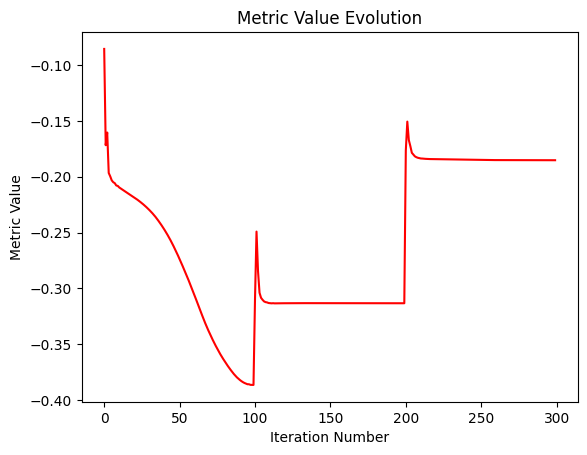

In [51]:
# Run the registration
final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                              sitk.Cast(moving_image, sitk.sitkFloat32))

In [52]:
# Now, apply this transform to the original top volume
resampler = sitk.ResampleImageFilter()
resampler.SetTransform(final_transform)

# Set the properties of the resampler to match the original top volume
resampler.SetOutputSpacing(fixed_image.GetSpacing())
resampler.SetSize(fixed_image.GetSize())
resampler.SetOutputDirection(fixed_image.GetDirection())
resampler.SetOutputOrigin(fixed_image.GetOrigin())
resampler.SetDefaultPixelValue(fixed_image.GetPixelIDValue())

# Apply the transformation
resampled_moving_image = resampler.Execute(moving_image)

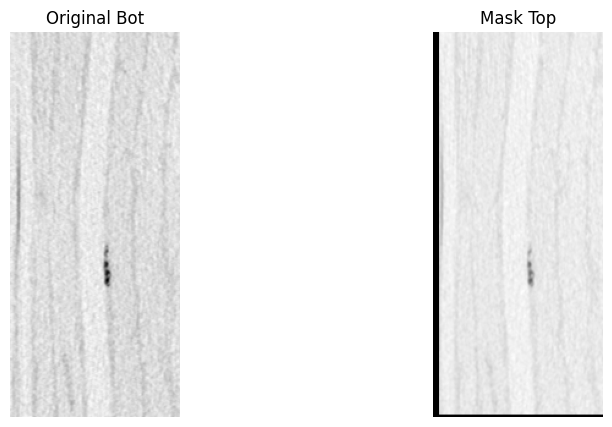

In [53]:
#plot a slice from the mask and the original volume
import matplotlib.pyplot as plt
slice_index = 1061
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sitk.GetArrayFromImage(fixed_image)[slice_index], cmap='gray')
plt.title('Original Bot')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sitk.GetArrayFromImage(resampled_moving_image)[slice_index], cmap='gray')
plt.title('Mask Top')
plt.axis('off')
plt.show()

In [54]:
# Now, apply the transform to the top volume overlaping reggion
resampler = sitk.ResampleImageFilter()
resampler.SetTransform(final_transform)

# Set the properties of the resampler to match the original top volume
resampler.SetOutputSpacing(fixed_image_full.GetSpacing())
resampler.SetSize(fixed_image_full.GetSize())
resampler.SetOutputDirection(fixed_image_full.GetDirection())
resampler.SetOutputOrigin(fixed_image_full.GetOrigin())
resampler.SetDefaultPixelValue(fixed_image_full.GetPixelIDValue())

# Apply the transformation
registered_volume_top_overlapping = resampler.Execute(moving_image_full)

# Apply the transformation
#final_top = resampler.Execute(final_top)

#registered_volume_top_overlapping = sitk.GetImageFromArray(sitk.GetArrayFromImage(final_top[:slice2]))

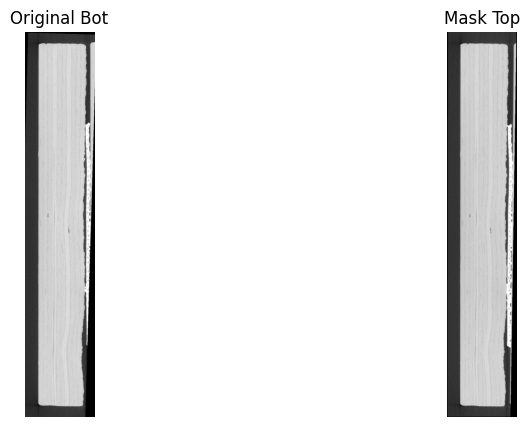

In [64]:
#plot a slice from the mask and the original volume
import matplotlib.pyplot as plt
slice_index = 1061
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sitk.GetArrayFromImage(fixed_image_full)[slice_index], cmap='gray')
plt.title('Original Bot')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sitk.GetArrayFromImage(registered_volume_top_overlapping)[slice_index], cmap='gray')
plt.title('Mask Top')
plt.axis('off')
plt.show()

In [62]:
# Now, apply the transform to the top volume overlaping reggion
resampler = sitk.ResampleImageFilter()
resampler.SetTransform(final_transform)

# Set the properties of the resampler to match the original top volume
resampler.SetOutputSpacing(final_bot.GetSpacing())
resampler.SetSize(final_bot.GetSize())
resampler.SetOutputDirection(final_bot.GetDirection())
resampler.SetOutputOrigin(final_bot.GetOrigin())
resampler.SetDefaultPixelValue(final_bot.GetPixelIDValue())

# Apply the transformation
final_top_2 = resampler.Execute(final_top)

registered_volume_top_overlapping_2 = sitk.GetImageFromArray(sitk.GetArrayFromImage(final_top_2[:slice2]))

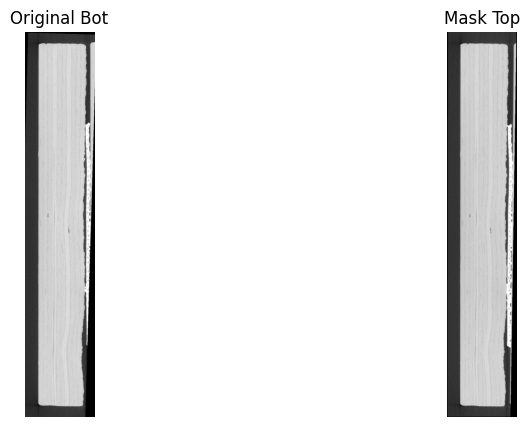

In [68]:
#plot a slice from the mask and the original volume
import matplotlib.pyplot as plt
slice_index = 1061
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sitk.GetArrayFromImage(fixed_image_full)[slice_index], cmap='gray')
plt.title('Original Bot')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sitk.GetArrayFromImage(registered_volume_top_overlapping_2)[slice_index], cmap='gray')
plt.title('Mask Top')
plt.axis('off')
plt.show()

In [69]:
mask_top_full = onlypores(sitk.GetArrayFromImage(registered_volume_top_overlapping))
moving_mask_image_full = sitk.GetImageFromArray(mask_top_full*255)

121


KeyboardInterrupt: 

In [ ]:

# Initial alignment of the two volumes
initial_transform2 = sitk.CenteredTransformInitializer(fixed_image_full, 
                                                      registered_volume_top_overlapping, 
                                                      sitk.AffineTransform(3), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

# Set up the registration framework
registration_method = sitk.ImageRegistrationMethod()

#mask settings
registration_method.SetMetricFixedMask(fixed_mask_image_full)
registration_method.SetMetricMovingMask(moving_mask_image_full)

# Similarity metric settings
#registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricAsMeanSquares()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.1)

# Interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings
registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0, minStep=1e-4, numberOfIterations=100, relaxationFactor=0.5, gradientMagnitudeTolerance=1e-8, estimateLearningRate=registration_method.EachIteration)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times
registration_method.SetInitialTransform(initial_transform2, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))


0

Performing registration at new resolution...
Performing registration at new resolution...
Performing registration at new resolution...


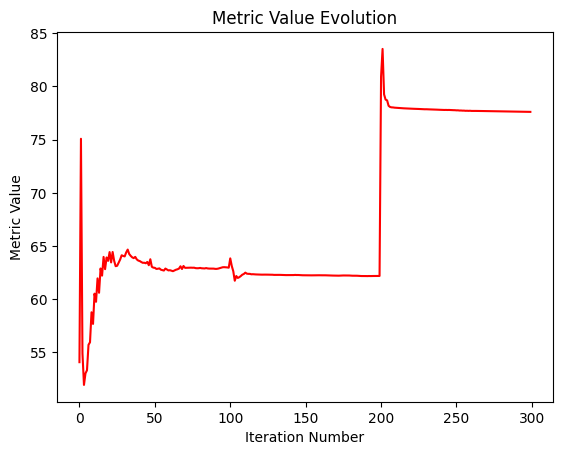

In [58]:
# Run the registration
final_transform2 = registration_method.Execute(sitk.Cast(fixed_image_full, sitk.sitkFloat32), 
                                              sitk.Cast(registered_volume_top_overlapping, sitk.sitkFloat32))

In [70]:
# Now, apply this transform to the original top volume
resampler = sitk.ResampleImageFilter()
resampler.SetTransform(final_transform2)

# Set the properties of the resampler to match the original top volume
resampler.SetOutputSpacing(final_bot.GetSpacing())
resampler.SetSize(final_bot.GetSize())
resampler.SetOutputDirection(final_bot.GetDirection())
resampler.SetOutputOrigin(final_bot.GetOrigin())
resampler.SetDefaultPixelValue(0) 

# Apply the transformation
registered_volume_top = resampler.Execute(final_top_2)

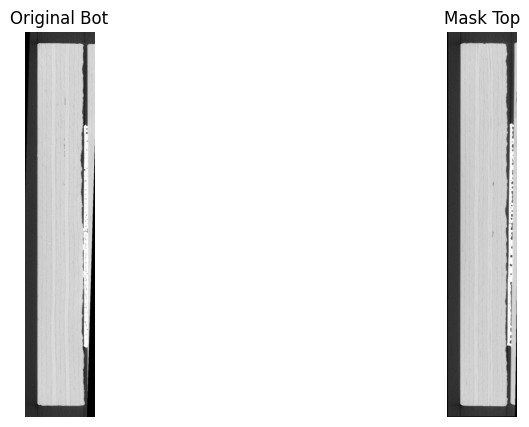

In [71]:
#plot a slice from the mask and the original volume
import matplotlib.pyplot as plt
slice_index = 2000
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sitk.GetArrayFromImage(final_bot)[slice_index], cmap='gray')
plt.title('Original Bot')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sitk.GetArrayFromImage(registered_volume_top)[slice_index], cmap='gray')
plt.title('Mask Top')
plt.axis('off')
plt.show()

In [72]:
#delete all files in folder
folder = Path(r'E:\temporal\volumenes\2+3+4+5\probando\3Dregistered_roi')
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

folder = Path(r'E:\temporal\volumenes\2+3+4+5\probando\3Dfixed_roi')
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

#delete all files in folder
folder = Path(r'E:\temporal\volumenes\2+3+4+5\probando\3Dregistered')
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

folder = Path(r'E:\temporal\volumenes\2+3+4+5\probando\3Dfixed')
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

#save the concatenated volume
output_folder = Path(r'E:\temporal\volumenes\2+3+4+5\probando')
write_sequence(output_folder, '3Dregistered_roi', sitk.GetArrayFromImage(resampled_moving_image))
write_sequence(output_folder, '3Dfixed_roi', sitk.GetArrayFromImage(fixed_image))
write_sequence(output_folder, '3Dregistered', sitk.GetArrayFromImage(registered_volume_top_overlapping_2))
write_sequence(output_folder, '3Dfixed', sitk.GetArrayFromImage(final_bot))

Saving: 100%|██████████| 1338/1338 [00:03<00:00, 386.93it/s]


Saving complete.


Saving: 100%|██████████| 1338/1338 [00:02<00:00, 531.83it/s]


Saving complete.


Saving: 100%|██████████| 4453/4453 [00:12<00:00, 363.93it/s]


Saving complete.


Saving: 100%|██████████| 4453/4453 [00:13<00:00, 322.84it/s]


Saving complete.
